In [1]:
import torch
from torch.utils.data import DataLoader

from torchvision.transforms import v2

import albumentations as A
from albumentations.pytorch import ToTensorV2

from tqdm.notebook import tqdm
import json
import numpy as np
###IE###
%load_ext autoreload
%autoreload 2
from utils.helpers import  plot_some_images ,read_images , pre_hard_skeletonize , pre_soft_skeletonize
from utils.preprocessing import WhiteTopHat , CLAHE , normalize_xca
from utils.dataset import  UnetDataset
from models.nnunet import nnUnet
from utils.losses import UnetLoss
from utils.recorder import HistoryRecorder
from logger import save_full_report
from trainer import trainer
###SS###

# Training

In [ ]:
args = {
    "base_path" : "../arcade/nnUnet_dataset/syntax",
    "in_c" : 1,
    "base_channel" :32,
    "image_shape" : (512,512),
    "class_count" : 26 ,
    "attention" : True,
    "k":40,
    "batch_size" : 10,
    "num_workers" : 10,
    "device" : "cuda" if torch.cuda.is_available() else "cpu",
    "lr" : 0.0001,
    "momentum" : 0.99,
    "epcohs":30,
    "f_int_scale" : 2,
    "full_report_cycle" : 10,
    "max_channels":512,
    "input_channels":1,
    "loss_type":"dice loss",
    "alpha":0.75,
    "beta":0.25,
    "gamma":1.00,
    "f_gamma":2.0,
    "f_loss_scale":1,
    "loss_coefs":{"CE":1.0,"Second":1.0},
    "output_base_path" : "./outputs",
    "name" : "Attention7-justDice"
}
class_map = {
    1: '1',2: '2', 3: '3',4: '4',
    5: '5',6: '6',7: '7',8: '8',
    9: '9',10: '9a',11: '10',12: '10a',
    13: '11',14: '12',15: '12a',16: '13',
    17: '14',18: '14a',19: '15',20: '16',
    21: '16a',22: '16b',23: '16c',
    24: '12b',25: '14b'
}
# losses_keys = ["total loss","FCE loss",args["loss_type"]]
losses_keys = ["total loss","CE loss",args["loss_type"]]

In [3]:
# with open("./data/train_class_counts.json","r") as f:
#     train_class_counts = json.load(f)

# b = 0.999999

# counts = [0]*(len(train_class_counts))
# for k,v in train_class_counts.items():
#     counts[int(k)] = int(v)
# counts = np.array(counts,dtype=np.float64)

# f_alpha = (1-b)/(1-np.power(b,counts))
# f_alpha = f_alpha / f_alpha.sum()
# f_alpha[12] = 0.25
# # args["f_alpha"] = f_alpha.tolist()
# args["f_alpha"]=None
# args["f_alpha"]

In [4]:
b=0.999
train_class_counts = [
    1200,374,375,369,303,525,525,
    340,310,198,70,21,1,320,61,
    129,305,107,49,38,232,43,48,31,63,127
]
f_alpha = (1-b)/(1-np.power(b,train_class_counts))
print(f_alpha)

[0.00143064 0.00320357 0.00319653 0.00323937 0.0038239  0.00244738
 0.00244738 0.003468   0.00375    0.00556448 0.01478441 0.04809698
 1.         0.00365007 0.01689033 0.00825881 0.00380244 0.00985004
 0.02090204 0.0268058  0.00482751 0.02374777 0.02132692 0.03274452
 0.01637033 0.00838066]


In [5]:
# pre_soft_skeletonize(args["base_path"],output_path=args["base_path"],batch_size=10,k=40)

In [6]:
train_transforms = A.Compose([
    A.GaussianBlur(
        sigma_limit=[0.1,0.5],
        p=0.5
    ),
    A.RandomBrightnessContrast(
        brightness_limit=0.1,
        contrast_limit=0.15,
        brightness_by_max=True,
        p=0.3
    ),
    A.RandomGamma(
        gamma_limit=(90, 120), 
        p=0.3
    ),
    A.Rotate(limit=15, p=0.3 , fill_mask = 0),
    A.HorizontalFlip(p=0.3),
    A.VerticalFlip(p=0.3),
    A.Lambda(image=normalize_xca),
    ToTensorV2()]
)
test_transforms = A.Compose([
    A.Lambda(image=normalize_xca),
    ToTensorV2()]  
)
# train_preprocess = v2.Compose([
#     WhiteTopHat(kernel_size=(50,50)),
#     CLAHE()
    
# ])
train_preprocess = None

In [7]:

train_images = read_images(base_path = args["base_path"],preprocessor = train_preprocess,part = "train")
valid_images = read_images(base_path = args["base_path"],preprocessor = train_preprocess,part = "val")

train_ds = UnetDataset(transform = train_transforms,data = train_images)
valid_ds = UnetDataset(transform = test_transforms,data = valid_images)

train_loader = DataLoader(
    train_ds,
    batch_size = args["batch_size"] ,
    num_workers = args["num_workers"] ,
    pin_memory=True,
    shuffle=True
)
valid_loader = DataLoader(
    valid_ds,
    batch_size = args["batch_size"] ,
    num_workers = args["num_workers"] ,
    pin_memory=True,
    shuffle=False,
)

NOTE : preprocessor is not defined . no preprocessing will be used !


  0%|          | 0/1000 [00:00<?, ?it/s]

NOTE : preprocessor is not defined . no preprocessing will be used !


  0%|          | 0/200 [00:00<?, ?it/s]

In [8]:
# plot_some_images(train_images, train_transforms, image_counts=36, fig_shape=(6,6), base_transforms=test_transforms)

In [9]:
model = nnUnet(args).to(args["device"])
loss_fn = UnetLoss(args)
# optimizer = torch.optim.Adam(model.parameters(), lr=args["lr"])
optimizer = torch.optim.SGD(model.parameters(),momentum=args["momentum"],lr=args["lr"])
recorder = HistoryRecorder(losses_keys=losses_keys,class_maps =class_map)
trainer(args,recorder,model,optimizer,loss_fn,train_loader,valid_loader)

number of layers : 7
encoder settings :  [32, 64, 128, 256, 512, 512, 512]
bottle-neck settings :  1024
decoder settings :  [1024, 1024, 512, 256, 128, 64]
head settings :  26
loss is set to dice


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (0)
total loss : 1.0205480626225472 - CE loss : 1.022432419359684 - dice loss : -0.0018843564784037882

train avg metrics for epoch 0 :
avg dice : 0.0010728313815348812 - avg precision : 0.0010935243073254242 - avg recall : 0.0054558781944069774
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (0)
total loss : 0.3326880231499672 - CE loss : 0.3343975871801376 - dice loss : -0.0017095613235142081

valid avg metrics for epoch 0 :
avg dice : 4.2089329715727303e-13 - avg precision : 0.0 - avg recall : 0.0
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (1)
total loss : 0.22603828832507133 - CE loss : 0.23255489498376847 - dice loss : -0.006516607068479061

train avg metrics for epoch 1 :
avg dice : 4.452890694587046e-13 - avg precision : 0.0 - avg recall : 0.0
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (1)
total loss : 0.197872132062912 - CE loss : 0.20922804698348046 - dice loss : -0.01135591478087008

valid avg metrics for epoch 1 :
avg dice : 4.2089329715727303e-13 - avg precision : 0.0 - avg recall : 0.0
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (2)
total loss : 0.16865585803985594 - CE loss : 0.18059609845280647 - dice loss : -0.011940239956602454

train avg metrics for epoch 2 :
avg dice : 4.4527172412129863e-13 - avg precision : 0.0 - avg recall : 0.0
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (2)
total loss : 0.17248895168304443 - CE loss : 0.1862323023378849 - dice loss : -0.01374335028231144

valid avg metrics for epoch 2 :
avg dice : 4.2089329715727303e-13 - avg precision : 0.0 - avg recall : 0.0
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (3)
total loss : 0.15637217313051224 - CE loss : 0.16969713792204857 - dice loss : -0.01332496446557343

train avg metrics for epoch 3 :
avg dice : 4.4666545476543123e-13 - avg precision : 0.0 - avg recall : 0.0
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (3)
total loss : 0.1657204583287239 - CE loss : 0.17965191155672072 - dice loss : -0.013931454066187144

valid avg metrics for epoch 3 :
avg dice : 4.2089329715727303e-13 - avg precision : 0.0 - avg recall : 0.0
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (4)
total loss : 0.14857974261045456 - CE loss : 0.16273602172732354 - dice loss : -0.014156279228627682

train avg metrics for epoch 4 :
avg dice : 4.47029852066285e-13 - avg precision : 0.0 - avg recall : 0.0
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (4)
total loss : 0.15736062675714493 - CE loss : 0.17278974130749702 - dice loss : -0.015429113665595651

valid avg metrics for epoch 4 :
avg dice : 4.2089329715727303e-13 - avg precision : 0.0 - avg recall : 0.0
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (5)
total loss : 0.14300765767693518 - CE loss : 0.1581636618077755 - dice loss : -0.015156004140153527

train avg metrics for epoch 5 :
avg dice : 1.3116904746359955e-05 - avg precision : 0.01353535294532776 - avg recall : 6.5616314532235265e-06
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (5)
total loss : 0.1554878421127796 - CE loss : 0.17160705849528313 - dice loss : -0.01611921829171479

valid avg metrics for epoch 5 :
avg dice : 0.00016292730388185663 - avg precision : 0.014069766998291015 - avg recall : 8.193807676434517e-05
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]


--- Gradient norms ---
encoders.0.layers.0.layers.0.weight: 3231.254639
encoders.0.layers.0.layers.0.bias: 0.128437
encoders.0.layers.0.layers.1.weight: 323.695679
encoders.0.layers.0.layers.1.bias: 580.883179
encoders.0.layers.1.layers.0.weight: 6952.215332
encoders.0.layers.1.layers.0.bias: 0.137130
encoders.0.layers.1.layers.1.weight: 807.999329
encoders.0.layers.1.layers.1.bias: 985.600464
encoders.1.layers.0.layers.0.weight: 14810.922852
encoders.1.layers.0.layers.0.bias: 0.220899
encoders.1.layers.0.layers.1.weight: 501.805908
encoders.1.layers.0.layers.1.bias: 514.624695
encoders.1.layers.1.layers.0.weight: 15553.547852
encoders.1.layers.1.layers.0.bias: 0.174082
encoders.1.layers.1.layers.1.weight: 405.362183
encoders.1.layers.1.layers.1.bias: 295.568298
encoders.2.layers.0.layers.0.weight: 13274.868164
encoders.2.layers.0.layers.0.bias: 0.120768
encoders.2.layers.0.layers.1.weight: 290.624451
encoders.2.layers.0.layers.1.bias: 267.617004
encoders.2.layers.1.layers.0.weight: 1

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (7)
total loss : 0.13431128792464733 - CE loss : 0.1512886106222868 - dice loss : -0.01697732218541205

train avg metrics for epoch 7 :
avg dice : 0.00021495636597159088 - avg precision : 0.009749560356140137 - avg recall : 0.00010867621749639511
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (7)
total loss : 0.14538922496140003 - CE loss : 0.16335022523999215 - dice loss : -0.017961000557988882

valid avg metrics for epoch 7 :
avg dice : 0.0001251266342117517 - avg precision : 0.004585883319377899 - avg recall : 6.342864595353604e-05
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

Saving Memory
Saving All Plots
Saving Examples


  0%|          | 0/18 [00:00<?, ?it/s]

Saving Verbal Results
Copying Notebook To Results
builfding kaggle project


100%|██████████| 9/9 [00:00<00:00, 2464.34it/s]


processing ./utils/dataset.py
processing ./utils/helpers.py
processing ./logger.py
processing ./utils/preprocessing.py
processing ./utils/recorder.py
processing ./models/nnunet_blocks.py
processing ./models/nnunet.py
processing ./utils/losses.py
processing ./trainer.py


100%|██████████| 1/1 [00:00<00:00,  2.67it/s]

processing ./temp_script.py


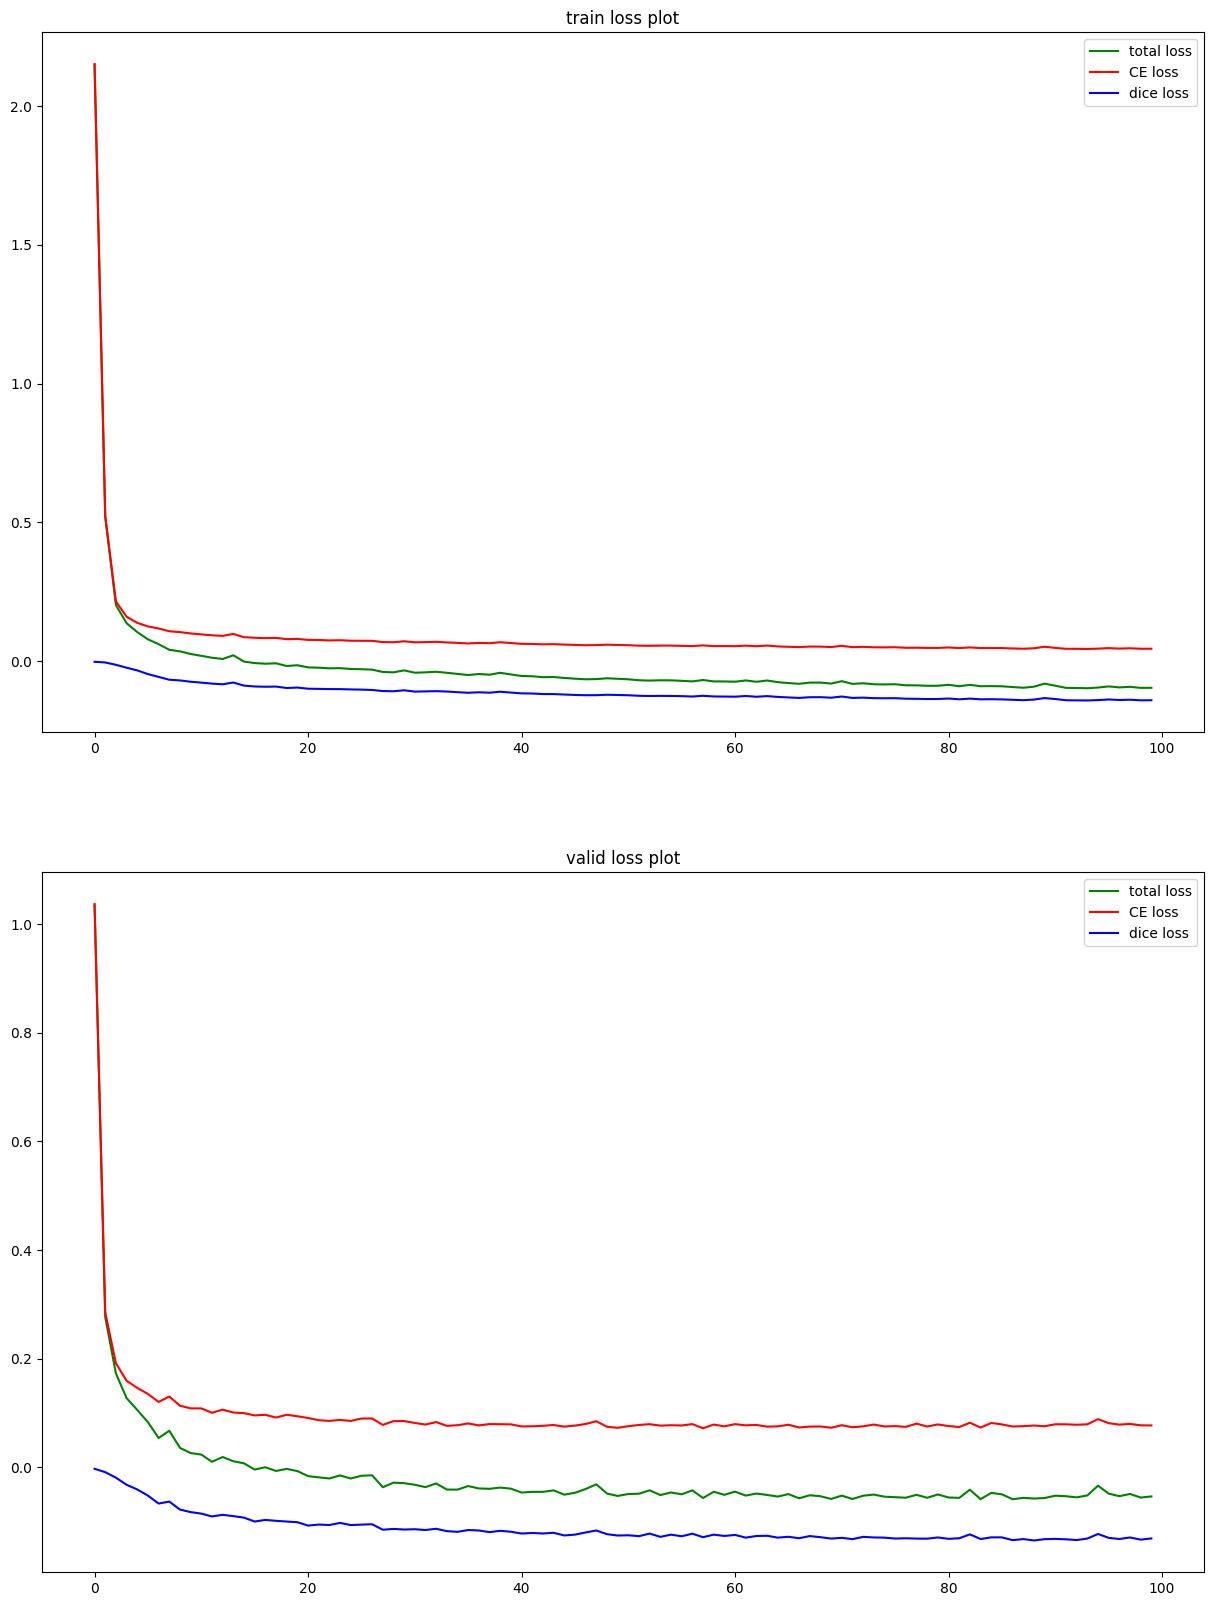

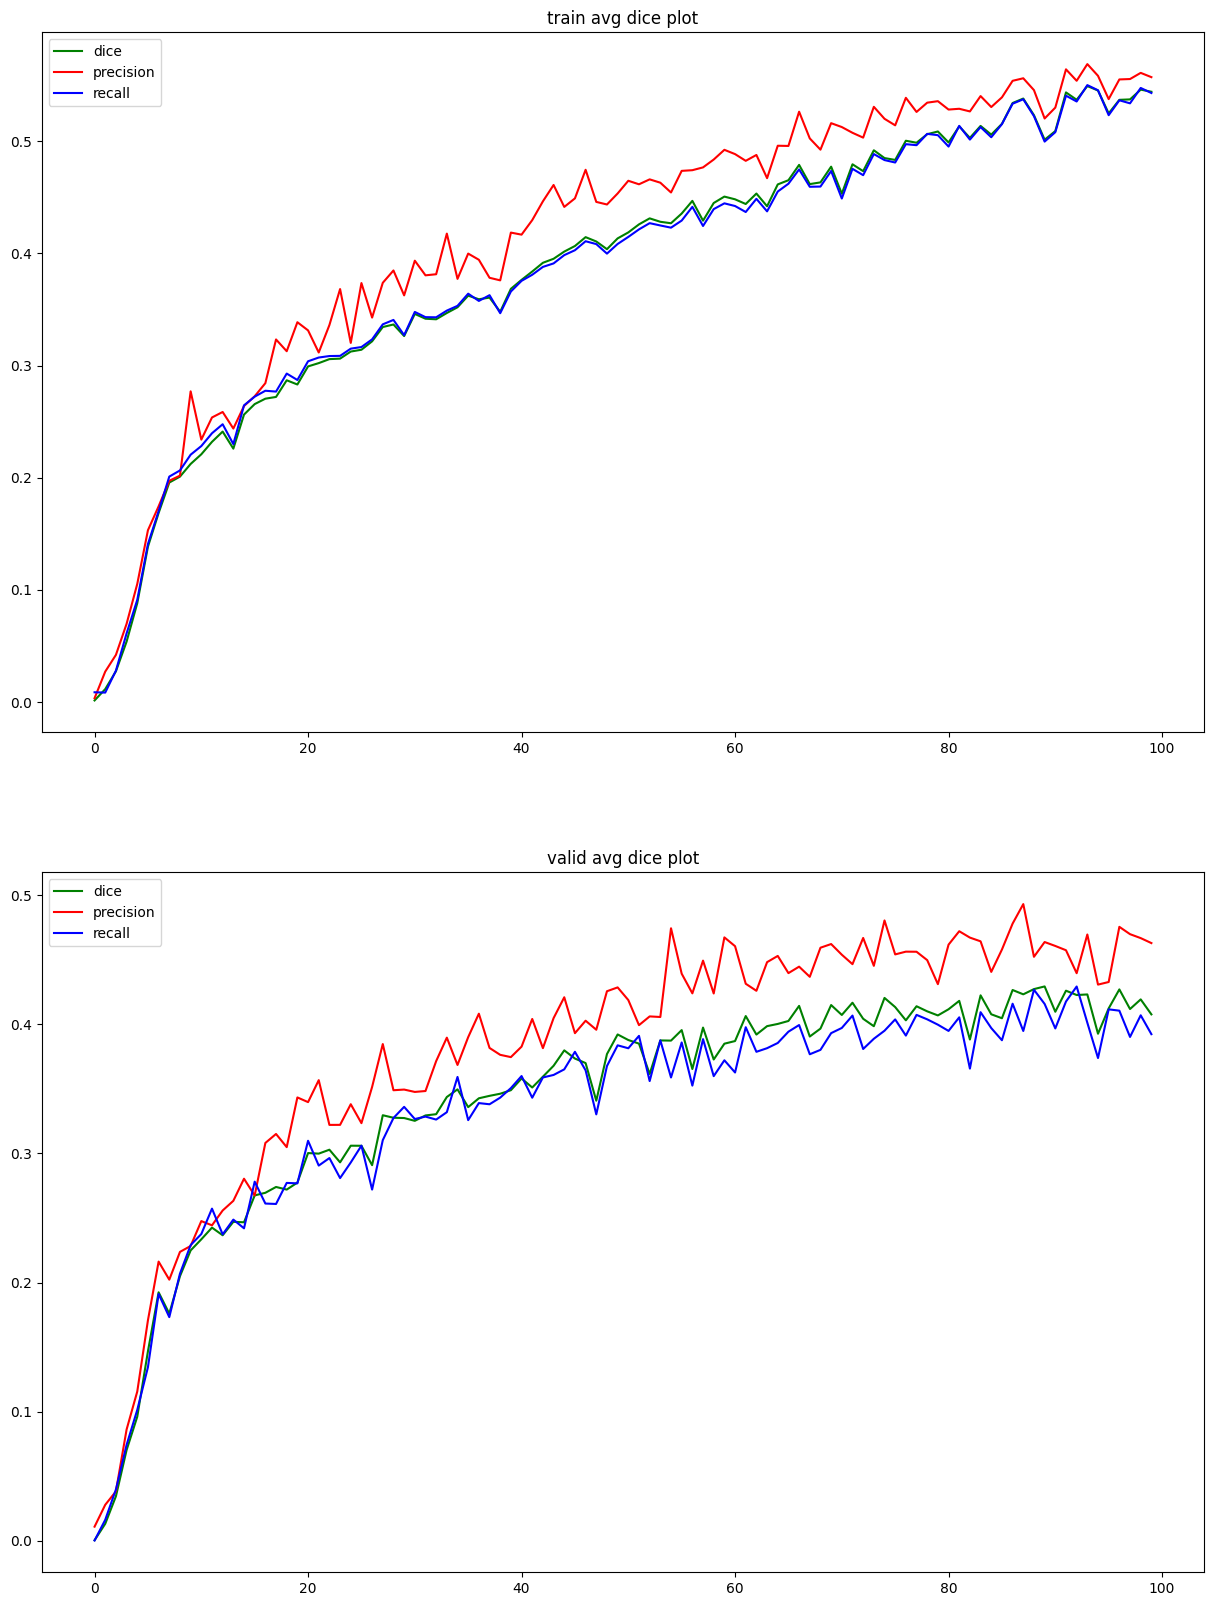

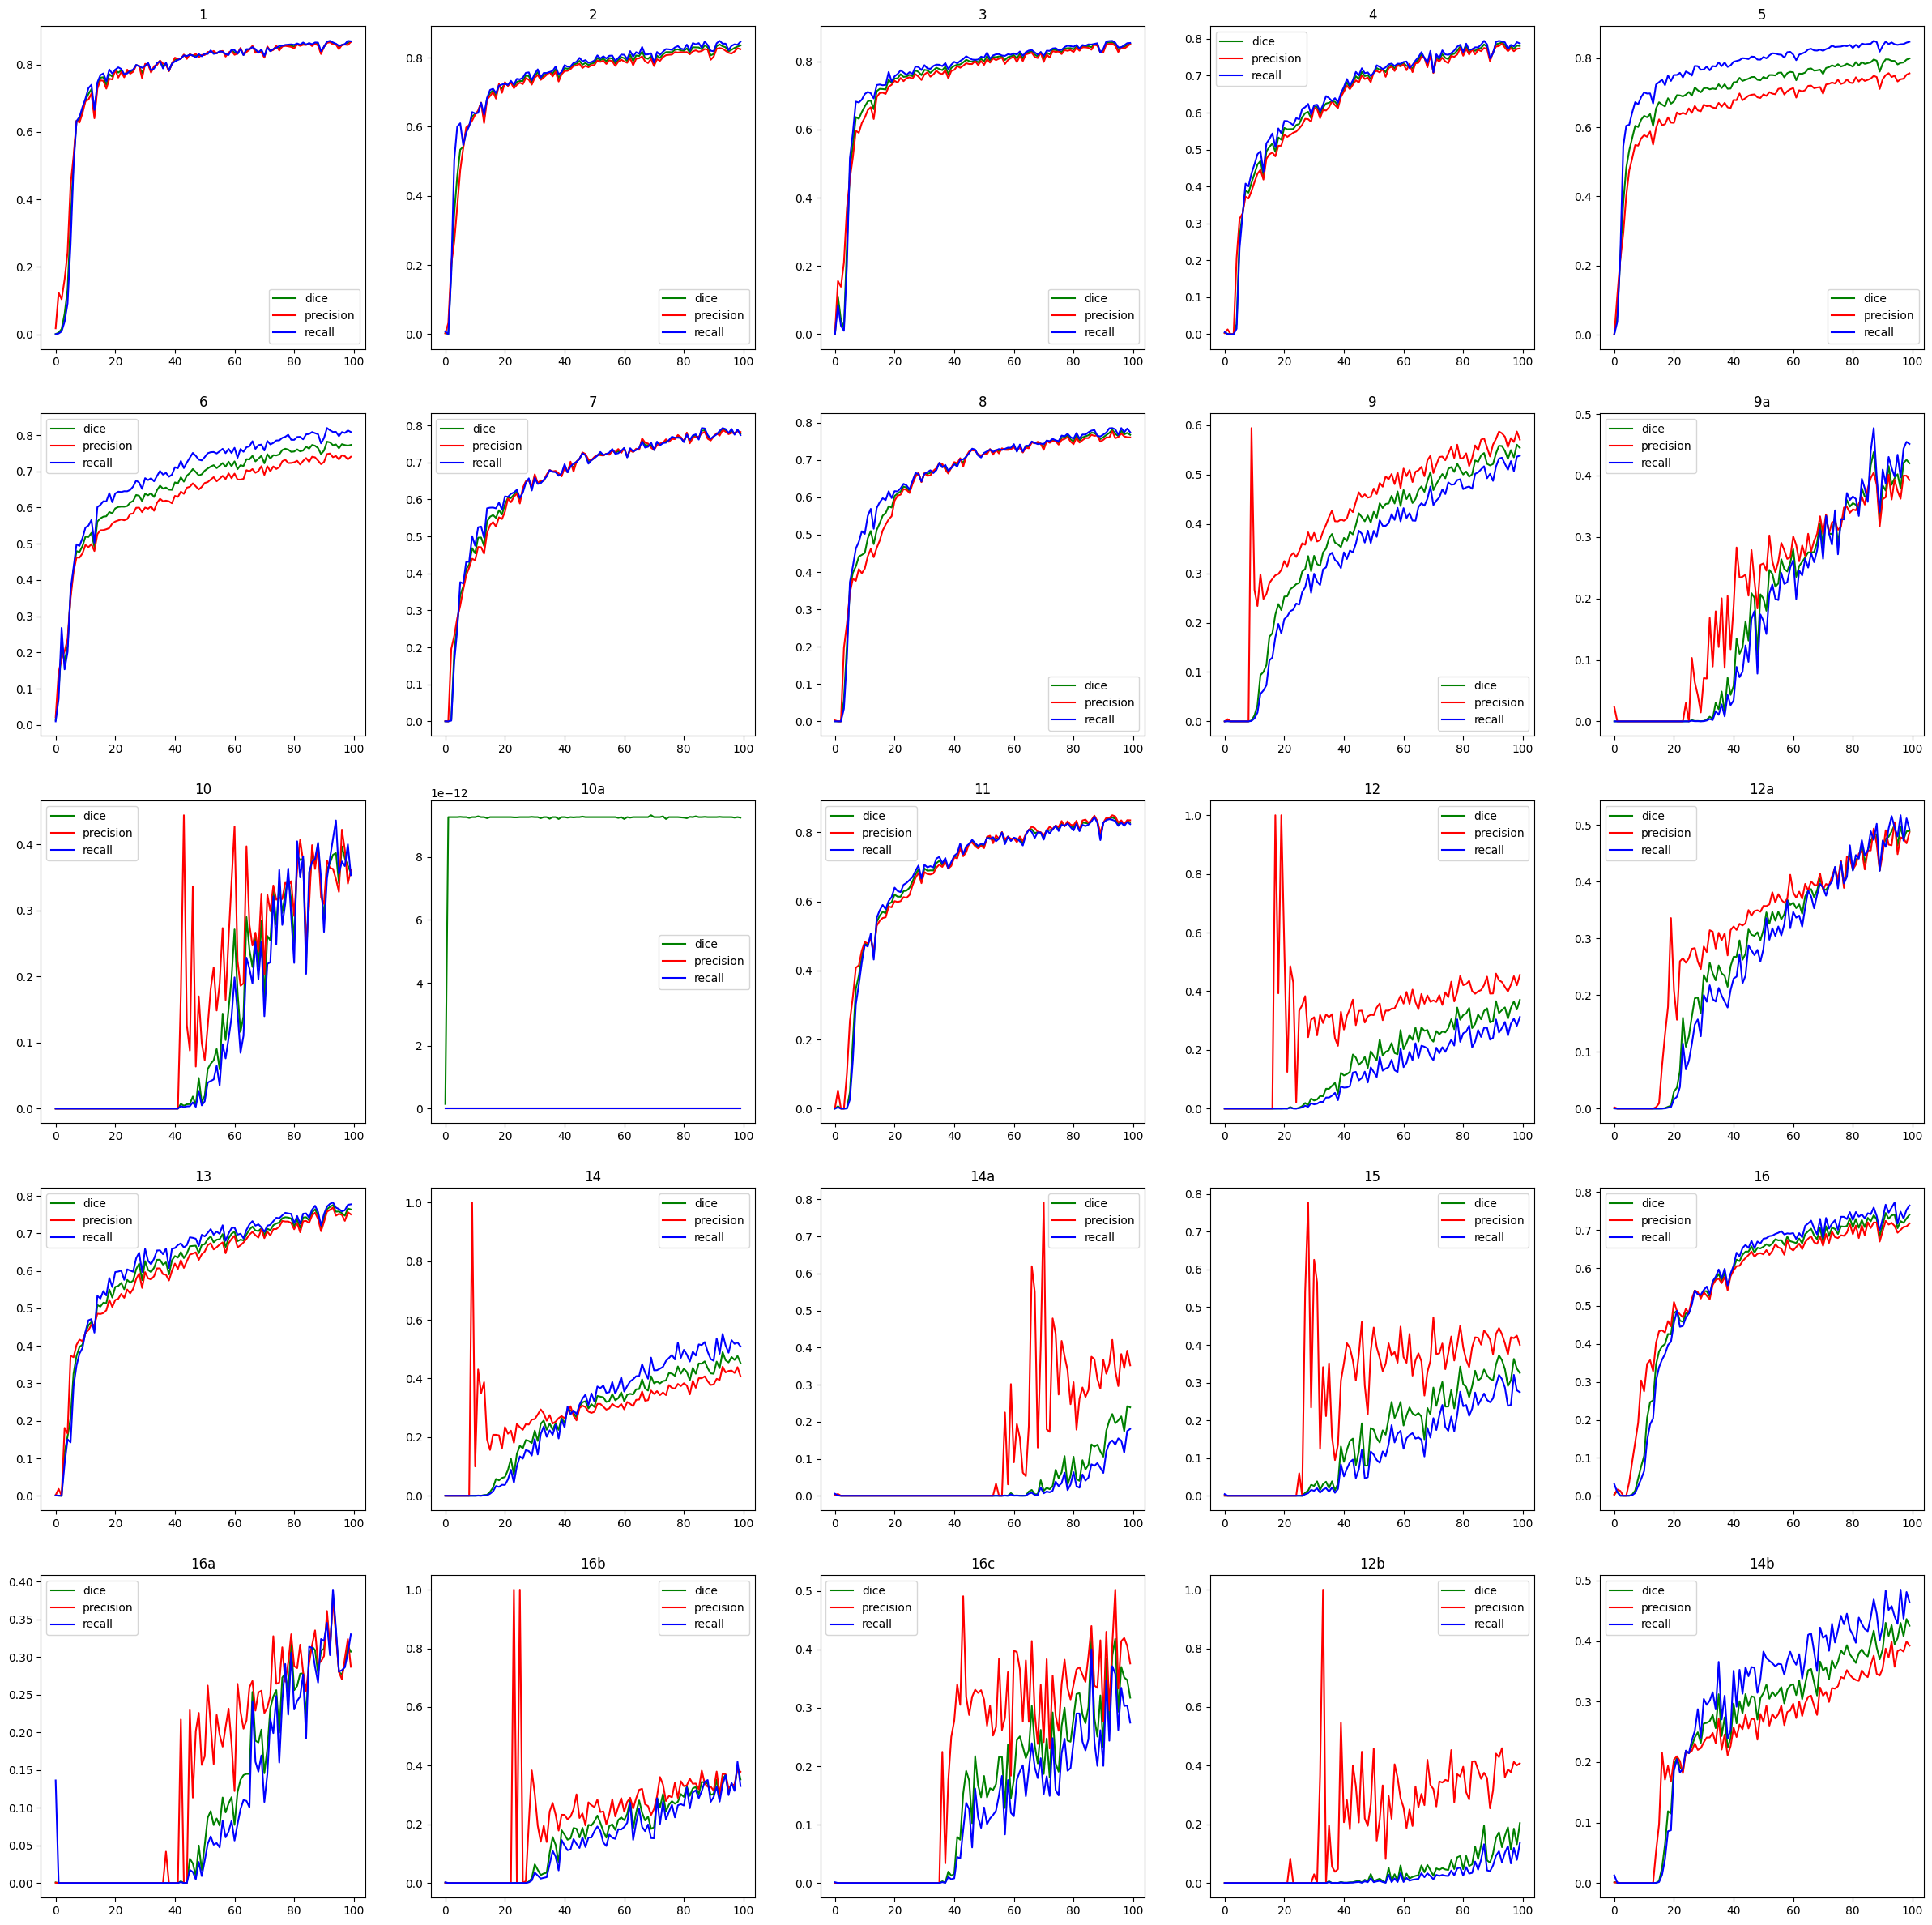

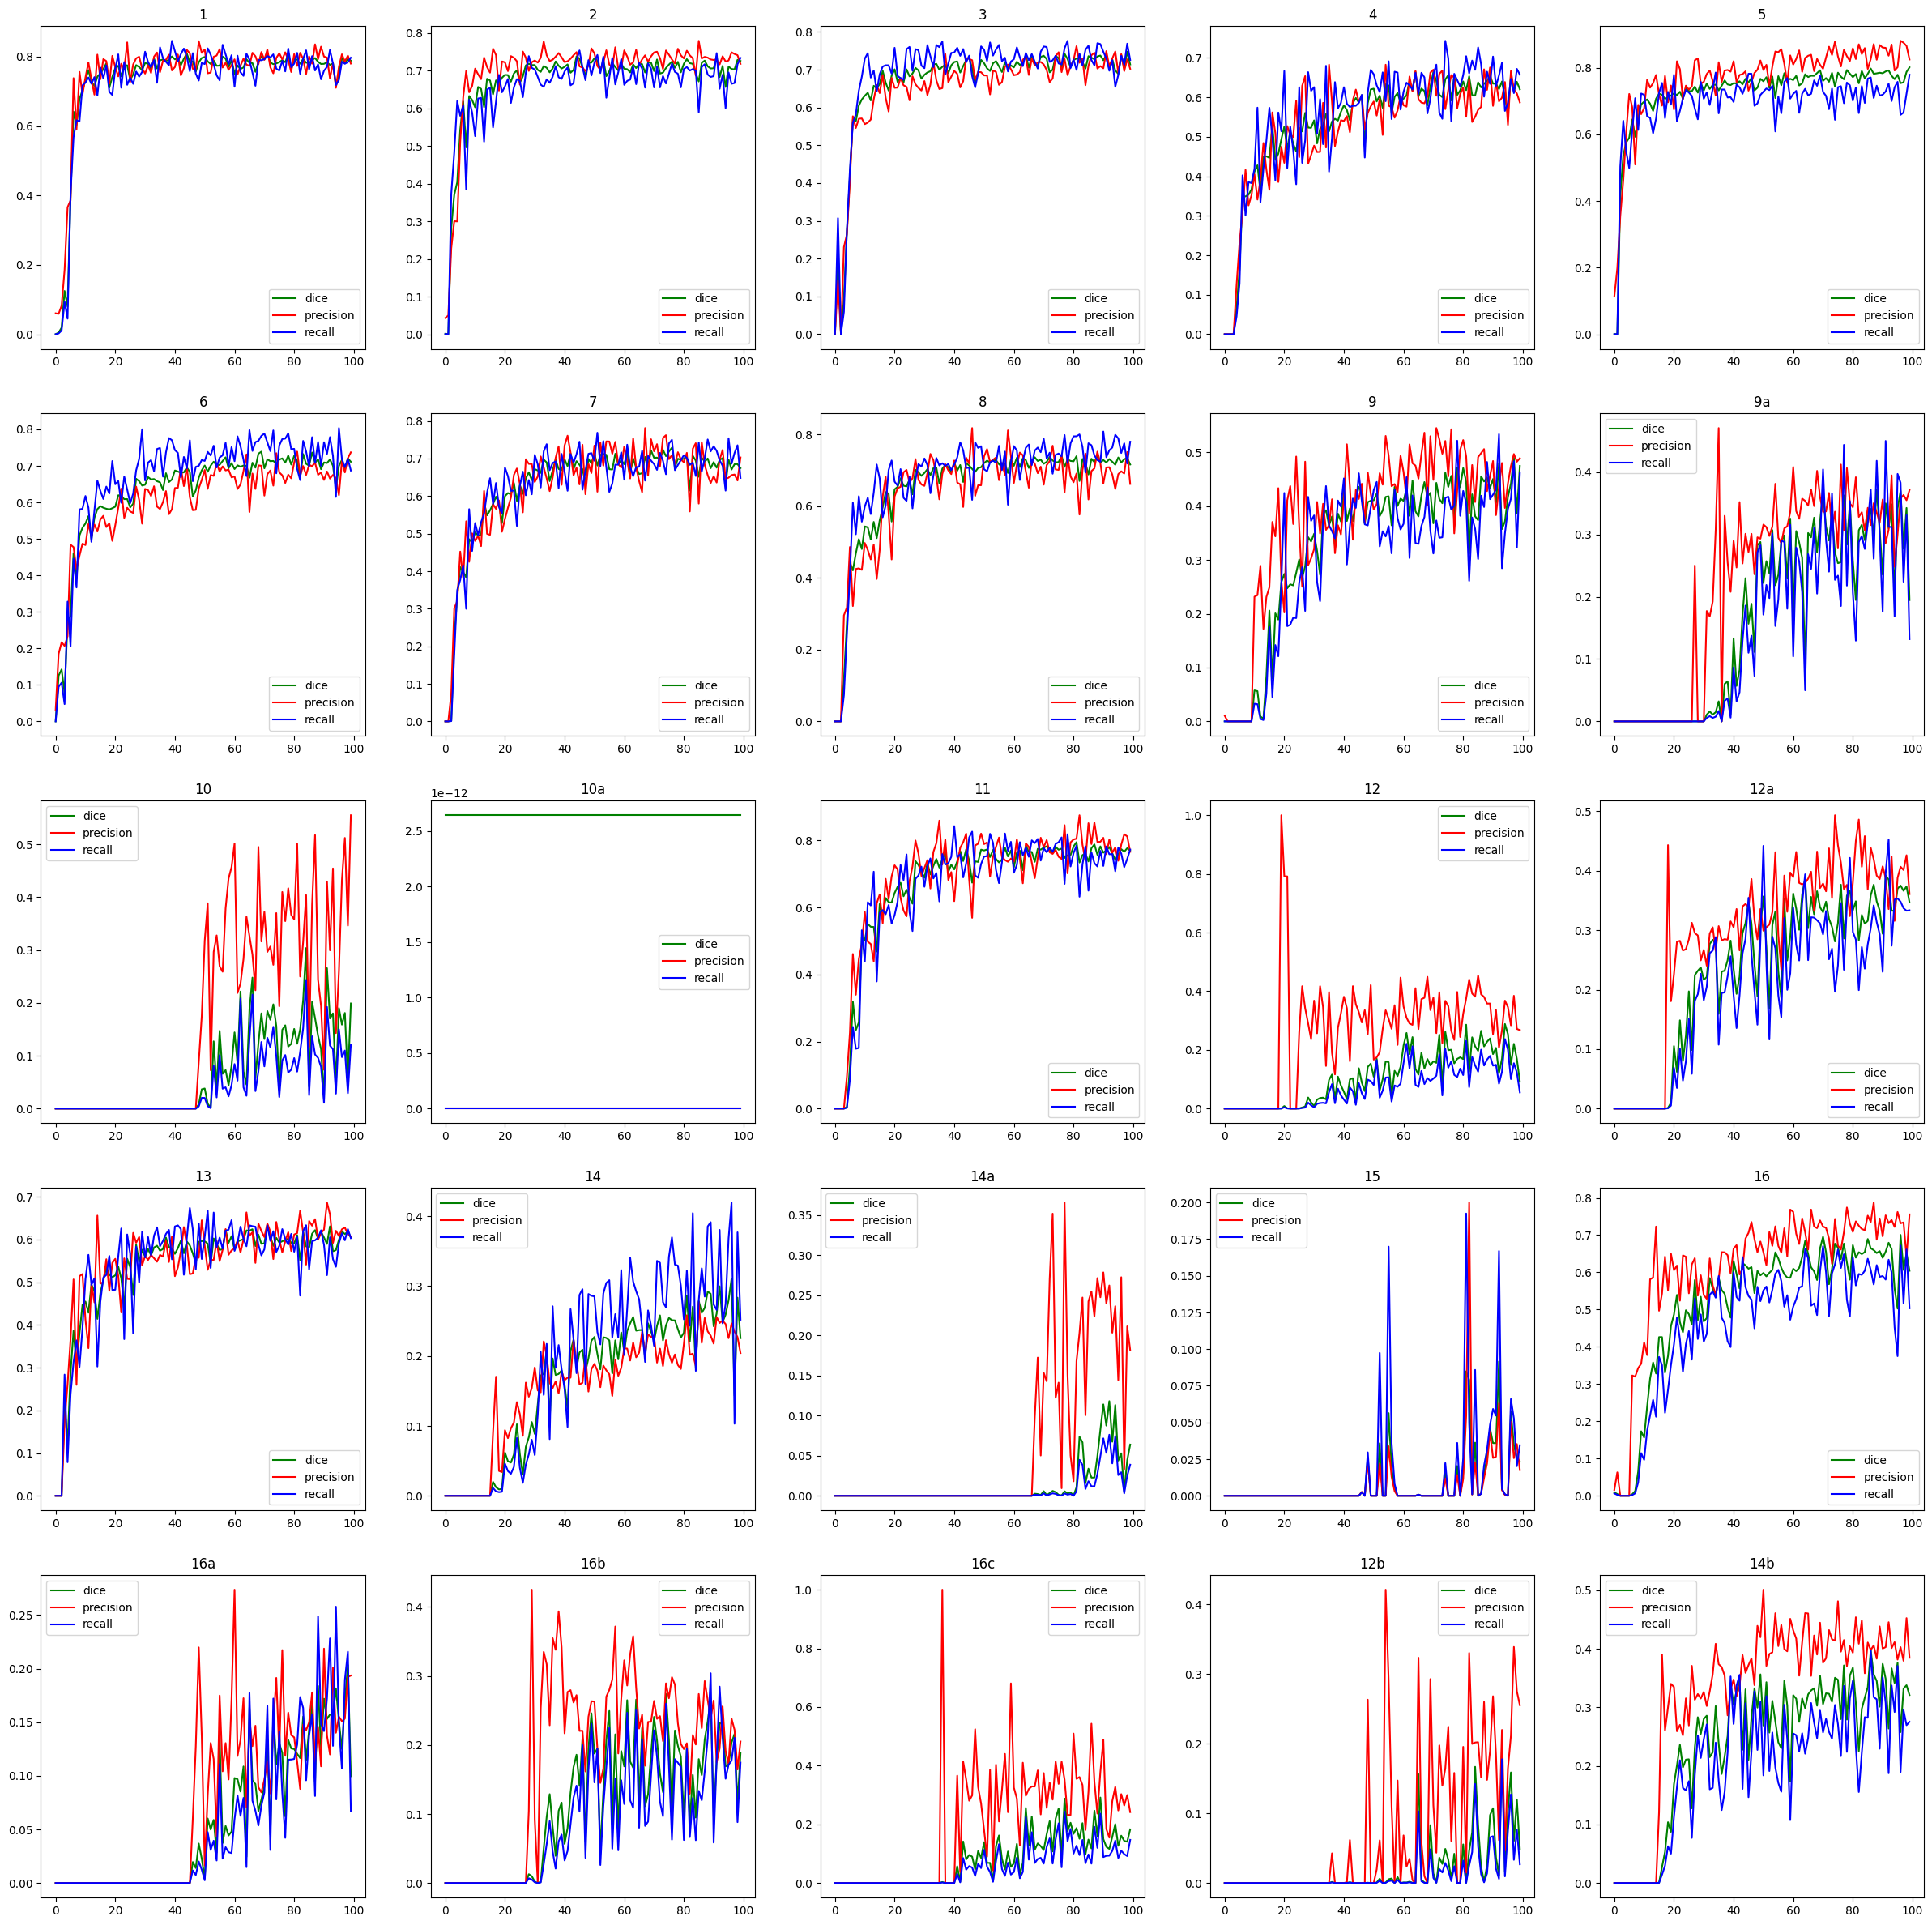

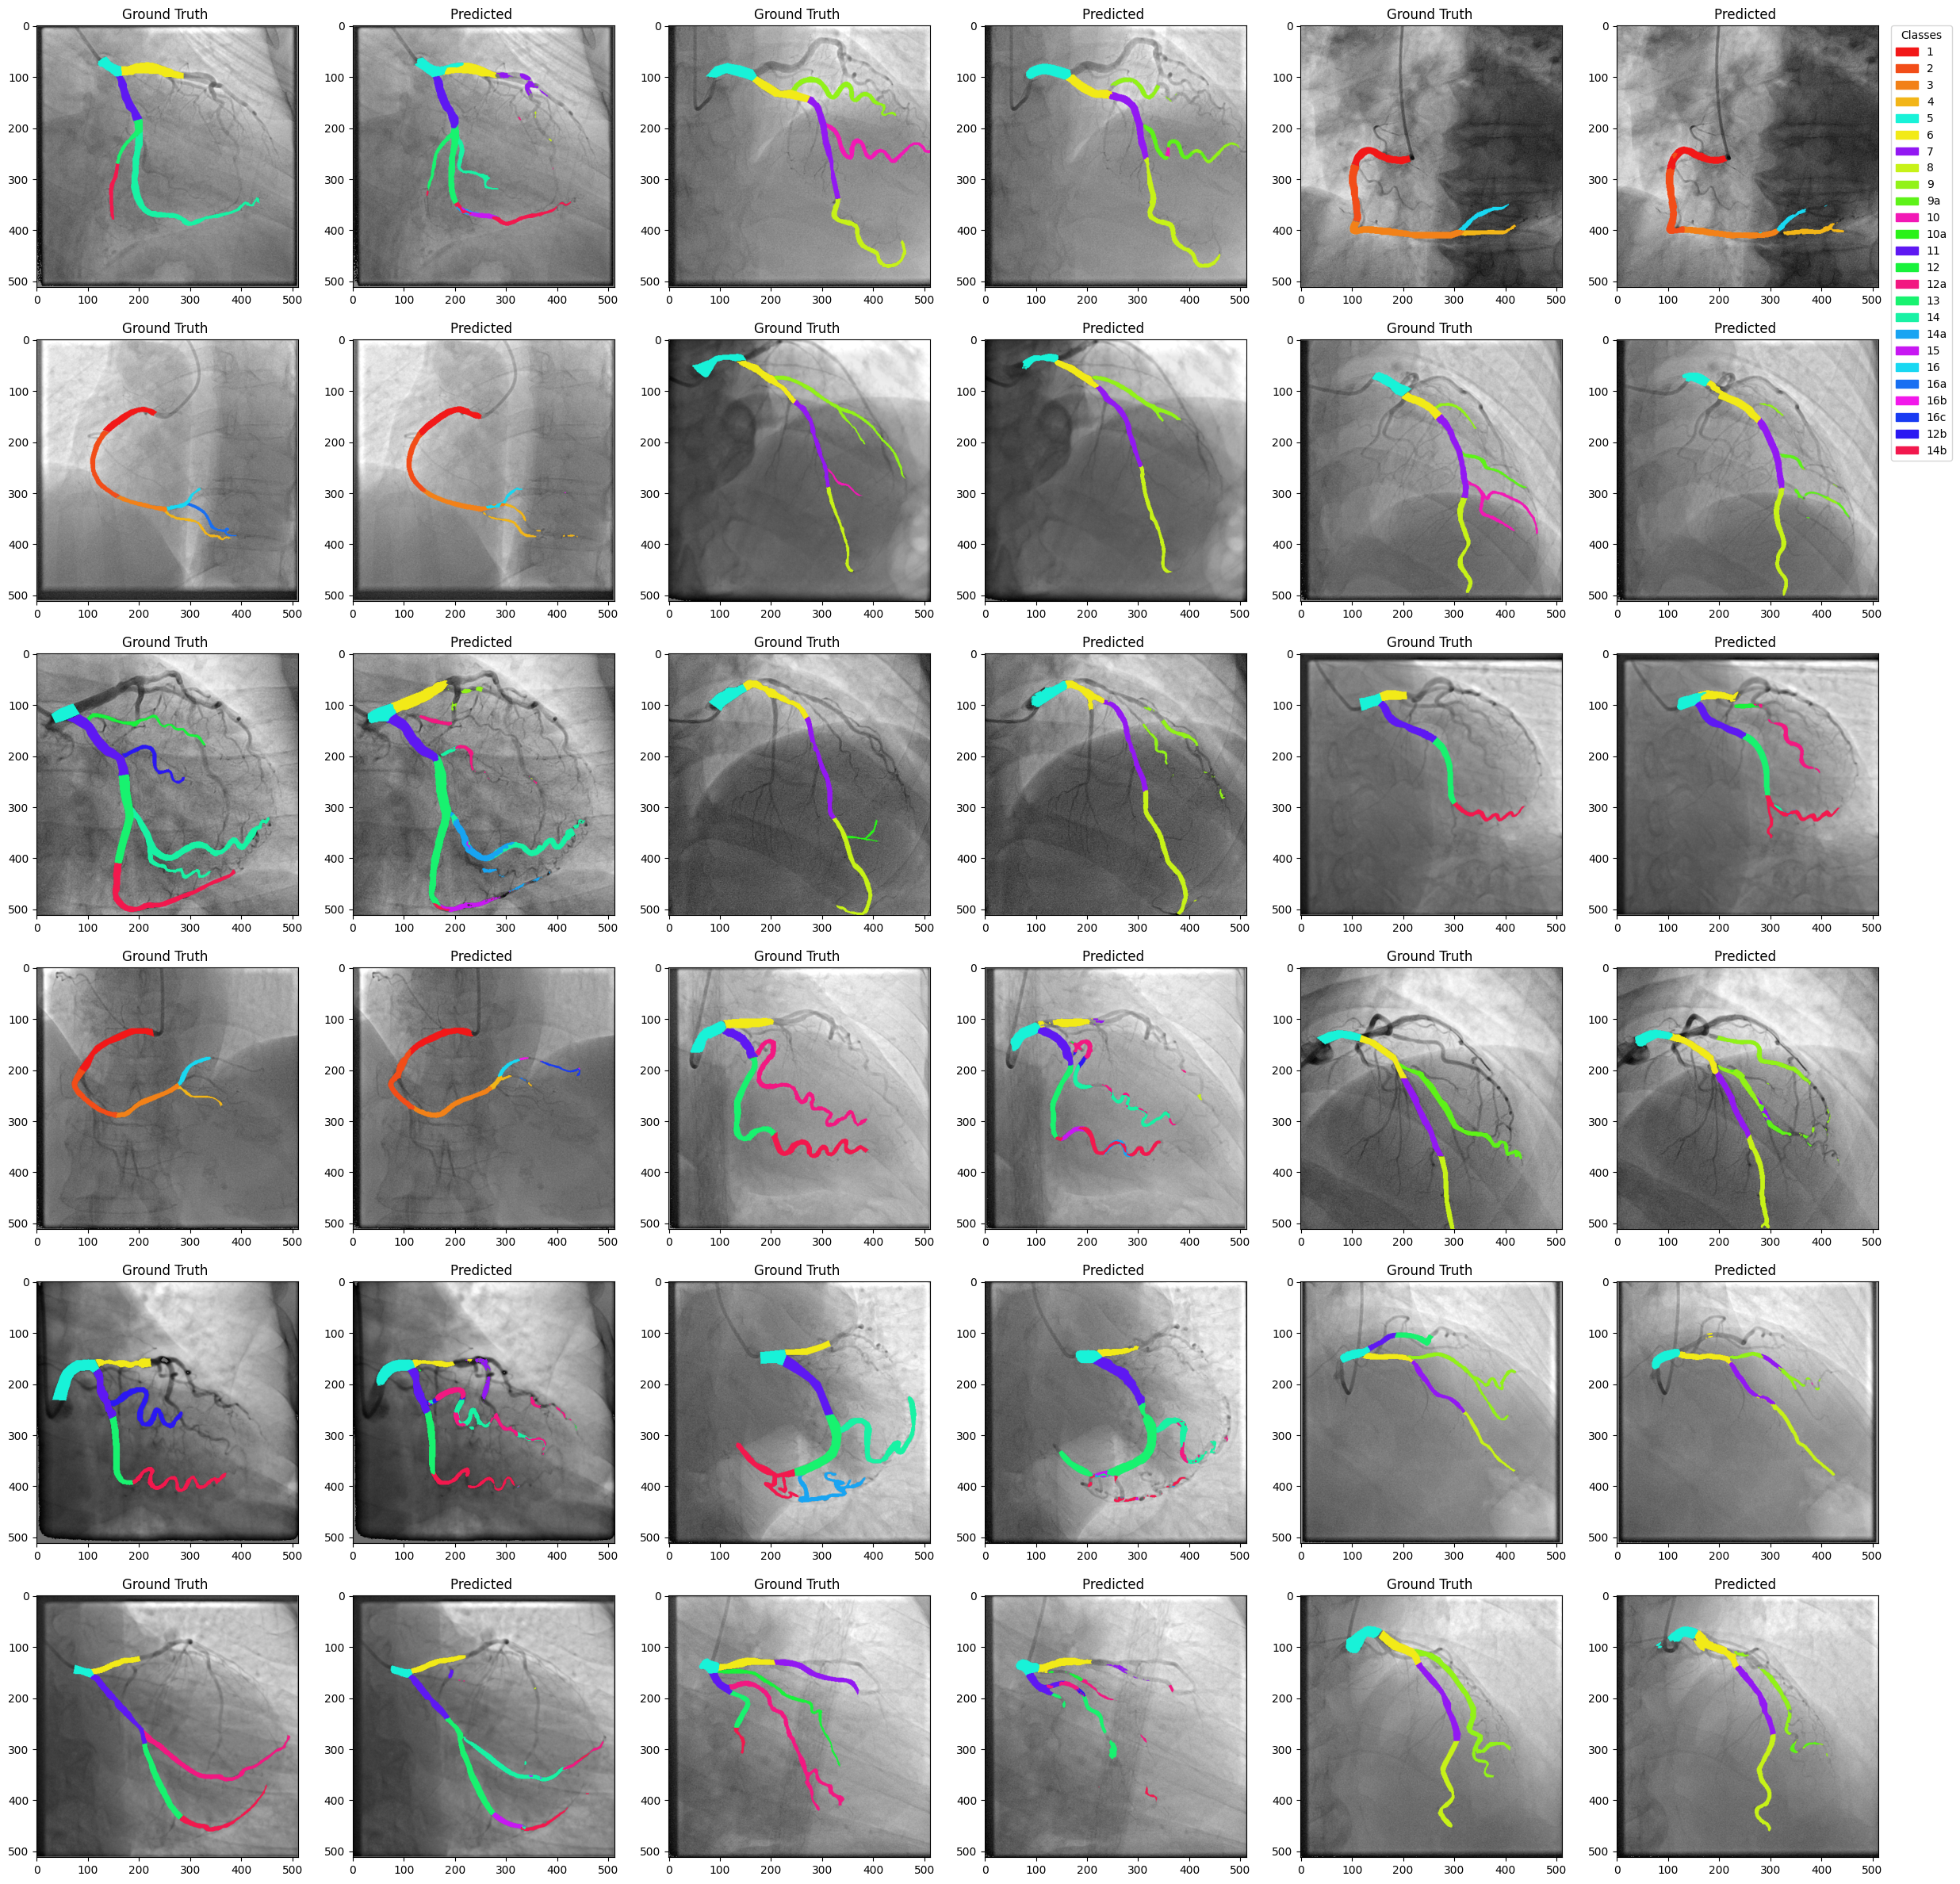

In [ ]:
save_full_report(
    recorder= recorder , 
    output_base_path=args["output_base_path"],
    model=model,
    valid_loader=valid_loader,
    args=args,
    class_map=class_map,
    name=args["name"]
)